# Part 6.6 - Analysis Topic Model of Specific Topics
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import filter_topics, plot_topics, plot_hot
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline
dpi=80

import datetime
print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-02-01 22:53:51


**In this part, we will define most significant topics and plot first 20 of them by combined plots.** 

**To evaluate and compare the distribution of topics, we use two basic metrics, in practice we use both to find interesting topics:**
1. The dominant topic counts. 

    Every document has a dominant topic represent the most portion of its contents. By summing the number of each dominant topic in a range of time, we see the variety and trend of each topic over time. It is easy to understand and fit for scatter plot, but in this way it ignores  non-dominant topics.

1. The average weight of topics over time.

    This metric is the average weight of a topic through all documents in a range of time, it avoid the issue above, reflect the topic variety and trend over time. However, it might give a frequent/normal topic (which has a small weight in each document) a high weight because the topic appears in large number of documents, when sum all weights of each topic and divid by total weight of all topics, this normal topic may get a high weight.
    

**To visualize the topics, we use all or part of below plots:**

1. word cloud to display topic words.

1. Scatter plot to dispaly the dominant tpics distribution over time.

1. Bar chart to display the dominant topics count over time.

1. Point plot to display the average topic weight over time.

## 1 Load dataframes

**Load the processed dataframes:**
* `topicKeys.txt`: topic words list
* `domTopic.csv`: document dominant topics dataframe
* `avgWeight.csv`: average topic weight dataframe

**Topics List:**

In [2]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic_', 'weight_', 'keywords_'],
                           encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape

In [3]:
print('Shape of dataframe:', topics_shape)
df_topics.head()

Shape of dataframe: (200, 3)


topic_  weight_  \
0       0  0.00161   
1       1  0.00908   
2       2  0.00116   
3       3  0.00893   
4       4  0.01761   

                                                                                                                 keywords_  
0  apply wanted good post work experience wellington position wages salary office experienced box required applications...  
1  killed police received people london persons hundred men explosion city women injured thousand number arrested wound...  
2  rooms price section bungalow deposit large modern home street garage kitchenette good sale post terms tram city view...  
3  meeting committee board motion chairman seconded moved thought matter present report carried messrs read resolution ...  
4  sydney south australia melbourne australian wales new_zealand received victoria queensland government federal adelai...

**Docmument - dominant topics dataframe:**

In [4]:
path = r'../models/train/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

In [5]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.sample(5)

Shape of dataframe: (3025602, 6)


id      region  year  topic    weight  \
2937341  32527548       Otago  1910     91  0.392781   
341434    4614428  Canterbury  1893    187  0.306960   
198263    3443433    National  1910    164  0.718802   
363326    4807314  Wellington  1937     83  0.402406   
488326    5935821  Wellington  1871    120  0.342959   

                                                                keywords  
2937341  don't man good it's boy i'm time day asked make back that's ...  
341434   sale acres land apply house property particulars sections se...  
198263   innings wickets cricket runs match team bowling total wicket...  
363326   meeting club members committee messrs secretary held annual ...  
488326   meeting evening held yesterday night morning messrs saturday...

**Average topic weight dataframe:**

In [6]:
path = r'../models/train/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

# short keywords for easy plot
df_avgweight['keywords'] = df_avgweight['keywords_'].str.slice(0,60)+'...'
df_avgweight.drop("keywords_", axis=1, inplace=True)

df_topics.columns = ['topic', 'weight', 'keywords']

In [7]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.sample(5)

Shape of dataframe: (20800, 4)


year  topic    weight  \
3762   1857    162  0.008533   
5637   1867     37  0.006834   
3343   1855    143  0.007206   
7574   1876    174  0.002513   
15920  1921    120  0.002312   

                                                              keywords  
3762   whangarei saturday monday tuesday friday wednesday thursday ...  
5637   goods ladies dress hats millinery stock prices department la...  
3343   natives native maori maoris government land islands auckland...  
7574   ploughs machines harrows machine plough implements agents ma...  
15920  meeting evening held yesterday night morning messrs saturday...

## General Distribution of Topics

### 2.1 Annual Average Weight Distribution

**We plot all the annual average weight to see the general distribution:**

In [8]:
df_plt = df_avgweight[['year', 'topic', 'weight']]

df_plt = pd.pivot_table(data=df_plt,
                        index='topic',
                        values='weight',
                        columns='year')
scaler = MinMaxScaler()
df_plt_scaled = pd.DataFrame(scaler.fit_transform(df_plt),columns = df_plt.columns)
df_plt.head()

year       1839      1840      1841      1842      1843      1844      1845  \
topic                                                                         
0      0.005073  0.000449  0.000049  0.000042  0.001198  0.000166  0.000084   
1      0.000030  0.000176  0.000946  0.002522  0.002282  0.003175  0.004854   
2      0.000004  0.000014  0.000016  0.000177  0.000014  0.000013  0.000015   
3      0.000029  0.007261  0.001829  0.007565  0.004898  0.005631  0.005014   
4      0.021866  0.009739  0.005646  0.004207  0.013800  0.006902  0.007129   

year       1846      1847      1848      1849      1850      1851      1852  \
topic                                                                         
0      0.000306  0.000163  0.000154  0.000379  0.000542  0.000173  0.000079   
1      0.001680  0.002620  0.006248  0.004410  0.002973  0.003341  0.002469   
2      0.000219  0.000022  0.000031  0.000163  0.000008  0.000014  0.000022   
3      0.003953  0.003612  0.002227  0.004002  0.002779  0.006103  0.007070   
4      0.005414  0.005956  0.004573  0.003708  0.003348  0.004921  0.005560   

year       1853      1854      1855      1856      1857      1858      1859  \
topic                                                                         
0      0.000174  0.000365  0.000244  0.000093  0.000183  0.000219  0.000143   
1      0.002326  0.002286  0.003000  0.002299  0.003754  0.004269  0.002253   
2      0.000051  0.000052  0.000057  0.000015  0.000029  0.000013  0.000015   
3      0.008712  0.008281  0.008649  0.008198  0.006838  0.007289  0.007777   
4      0.004398  0.002600  0.002834  0.002474  0.003503  0.004589  0.004050   

year       1860      1861      1862      1863      1864      1865      1866  \
topic                                                                         
0      0.000110  0.000402  0.000366  0.000179  0.000145  0.000285  0.000223   
1      0.002648  0.002972  0.001616  0.002984  0.002931  0.002033  0.002255   
2      0.000039  0.000093  0.000049  0.000071  0.000037  0.000028  0.000036   
3      0.006157  0.005297  0.006575  0.006053  0.006169  0.005787  0.006510   
4      0.003060  0.003429  0.006373  0.005637  0.004923  0.003643  0.005086   

year       1867      1868      1869      1870      1871      1872      1873  \
topic                                                                         
0      0.000125  0.000099  0.000175  0.000138  0.000241  0.000129  0.000203   
1      0.002142  0.002880  0.002136  0.002383  0.003545  0.002705  0.001545   
2      0.000044  0.000072  0.000048  0.000045  0.000047  0.000050  0.000038   
3      0.007023  0.008718  0.008907  0.008308  0.008103  0.008059  0.008842   
4      0.003633  0.004690  0.004564  0.004446  0.004223  0.005611  0.006421   

year       1874      1875      1876      1877      1878      1879      1880  \
topic                                                                         
0      0.000241  0.000196  0.000206  0.000321  0.000264  0.000255  0.000226   
1      0.002351  0.001945  0.002270  0.002702  0.002682  0.003326  0.003342   
2      0.000059  0.000064  0.000069  0.000066  0.000083  0.000081  0.000078   
3      0.008050  0.009491  0.009023  0.009641  0.008998  0.009400  0.008205   
4      0.005423  0.005352  0.008088  0.009412  0.009120  0.013363  0.013060   

year       1881      1882      1883      1884      1885      1886      1887  \
topic                                                                         
0      0.000148  0.000162  0.000192  0.000172  0.000210  0.000202  0.000178   
1      0.004552  0.004462  0.006118  0.004630  0.003619  0.005492  0.006798   
2      0.000074  0.000081  0.000069  0.000065  0.000089  0.000064  0.000080   
3      0.008849  0.007786  0.008117  0.008203  0.007898  0.008992  0.008208   
4      0.011396  0.011713  0.015503  0.014684  0.015542  0.015401  0.015322   

year       1888      1889      1890      1891      1892      1893      1894  \
topic                                      

**Plot:** <a name="hot"></a>

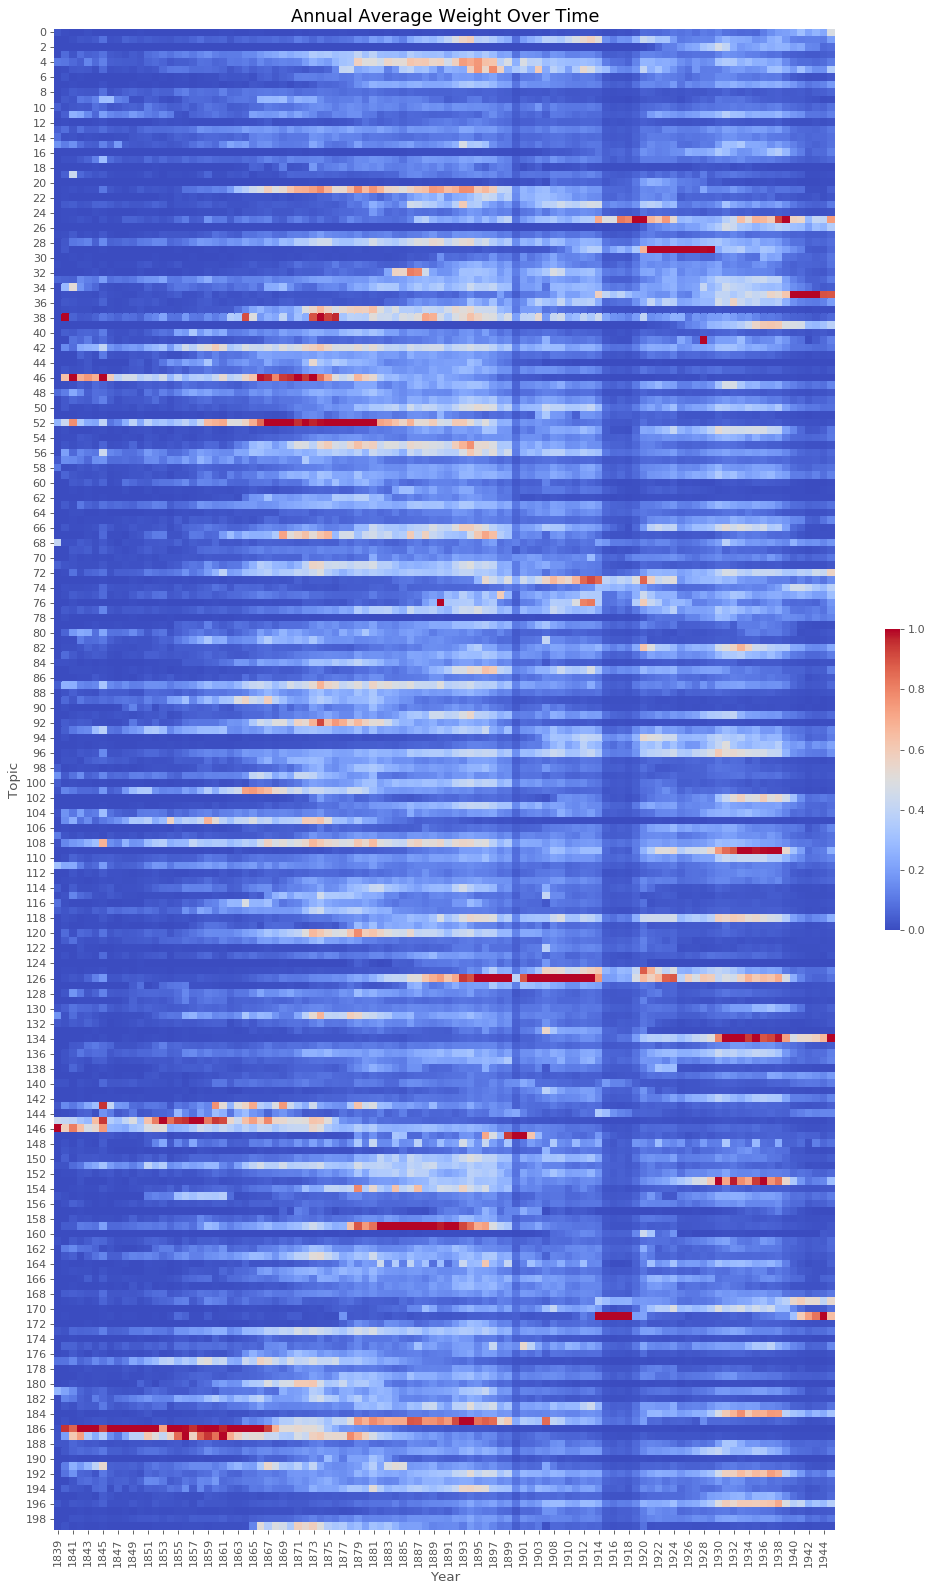

In [9]:
fig, ax = plt.subplots(figsize=(13, 20), dpi=80)

sns.heatmap(df_plt_scaled,
            cmap='coolwarm',
            cbar=True,
            cbar_kws={"shrink": .2},
            annot=False,
            square=True,
            ax=ax
            )
plt.xlabel('Year')
plt.ylabel('Topic')
plt.title("Annual Average Weight Over Time", fontdict=dict(size=16))
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

### 2.2 Annual Average Weight of Each Topic

**Plot all topics average weight to check trend of each topic.**

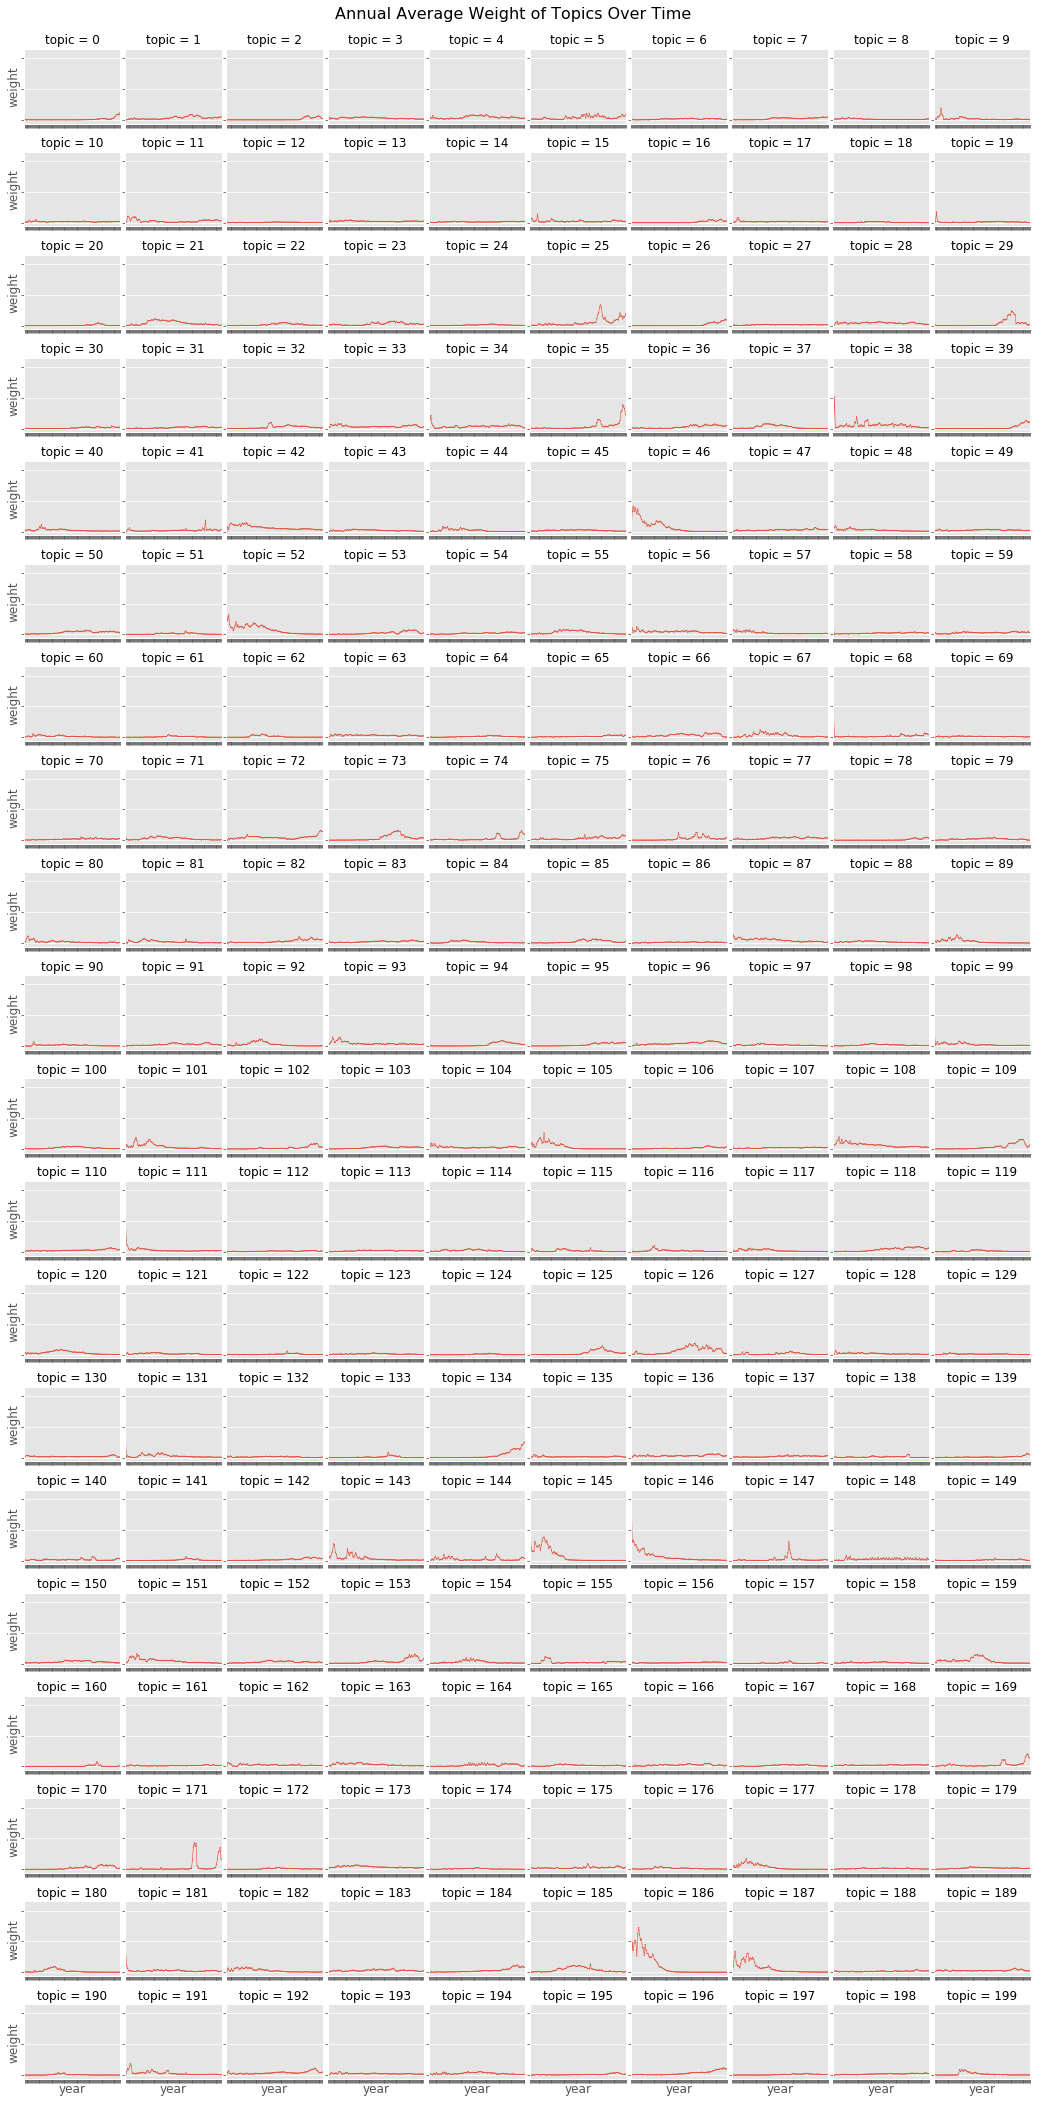

In [10]:
g = sns.catplot(x="year", y='weight',  col='topic', col_wrap=10, 
                kind='point', height=1.5, aspect=1, dodge=False, s=0.2, legend=False, 
                markers='.', scale=0.2,
                data=df_avgweight)
g.fig.suptitle("Annual Average Weight of Topics Over Time", fontsize=16)
g.set_xticklabels(visible=False)
g.set_yticklabels(visible=False)
g.fig.subplots_adjust(top=0.96, hspace=0.4, wspace=0.05)

## 3 Specific Topics

### 3.1 The Most Hot Topics

**From the [Annual Average Weight Over Time plot](#hot) we see the red spots, each red spot means this topic (y axis) is the hotest topic of this year (x axis), some topics are the hotest topic in continuely years. We filter out the hot topics and sort them by the count of being hot topic, which are the most hot topics.**

In [11]:
df_hot = pd.DataFrame(df_plt_scaled.astype(int).sum(axis=1), columns=['count'])
df_hot = df_hot[(df_hot != 0).any(axis=1)].sort_values(by='count', ascending=False)
topic_list = df_hot.index.tolist()
print('Most hot topics:')
df_hot.T

Most hot topics:


186  52   126  159  171  29   134  109  145  25   46   35   147  38   \
count   16   12   10    8    6    4    4    4    3    3    3    3    2    2   

       185  76   153  41   187  
count    2    1    1    1    1

In [12]:
df_topics_hot = filter_topics(df_topics, topic_list).set_index('topic')
df_topics_hot.loc[topic_list].head(len(topic_list))

weight  \
topic            
186    0.00390   
52     0.01537   
126    0.03778   
159    0.00787   
171    0.00752   
29     0.00615   
134    0.00987   
109    0.00694   
145    0.00537   
25     0.01345   
46     0.00382   
35     0.00953   
147    0.00679   
38     0.03950   
185    0.00984   
76     0.00782   
153    0.00625   
41     0.00436   
187    0.00756   

                                                                                                                      keywords  
topic                                                                                                                           
186      cases casks ditto boxes sale case oil brandy bags ale tea sugar foot candles cwt tons iron white tobacco undersigned   
52     business public notice orders begs attention stock street goods general premises inform prices customers advertiseme...  
126    association press telegraph received copyright london united electric cable sydney april march news australian octob...  
159    london government french british foreign sir news england lord paris received english france general great prince ma...  
171    german enemy germans front french london british fighting troops attack captured received russian artillery line sta...  
29     theatre picture pictures story programme film to-night drama comedy love star shown girl life great feature supporti...  
134    new_zealand government work made scheme system industry national dominion control conditions country present time pu...  
109    beat club played match play game championship won players tennis team games round wellington tournament matches satu...  
145    government provincial province council colony general superintendent governor public assembly colonial honor new_zea...  
25     german germany received peace war berlin government france london paris french states russia italy correspondent bri...  
46     tons schooner cases barque melbourne agents passengers agent case port bags cargo early cutter sailed wellington lyt...  
35     air british naval german ships navy fleet london sea submarine vessels admiral war admiralty received flying ship to...  
147    south africa boers british general war transvaal boer london lord received african cape capetown troops contingent p...  
38                                      tin ill oil day lit zealand mil ton tie hat aro fur aid ail end tins man hut time win   
185    wellington arrived nelson morning sailed auckland tons to-morrow port to-day lyttelton westport coast south picton l...  
76     strike union men miners coal labour work workers association federation conference labor strikers wages received uni...  
153         race meeting racing cup club good horses horse won handicap day races stakes jockey run winner win mile ran great   
41     auckland wellington left due london january december lyttelton march october april february november september sydne...  
187    sale acres land apply house property particulars sections section town terms good situated road farm street freehold...

**Plot all hot topics with:**
* annual average weight
* dominant topic distribution
* dominant topic count

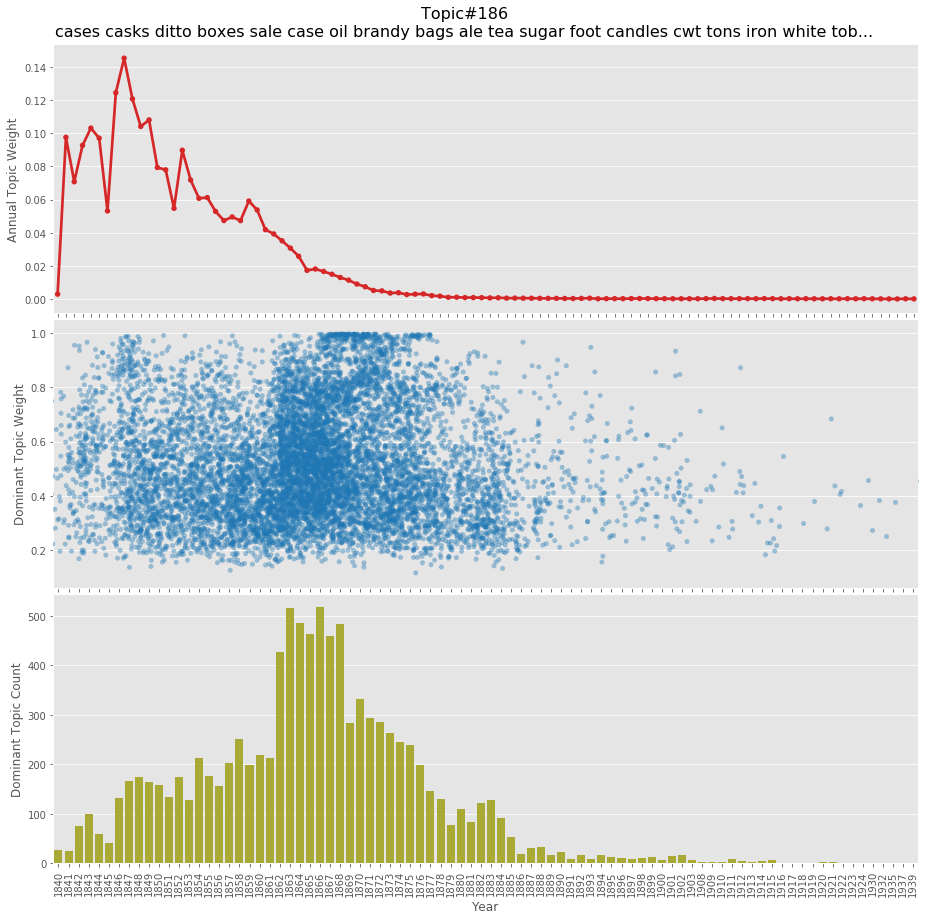

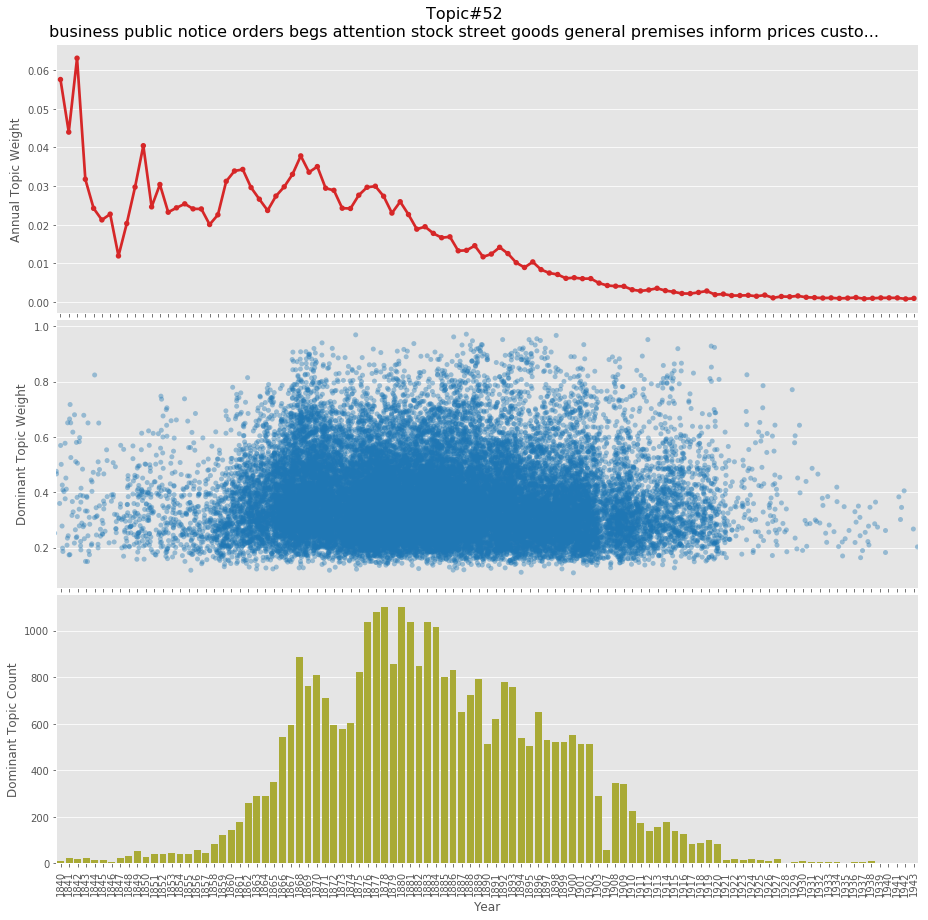

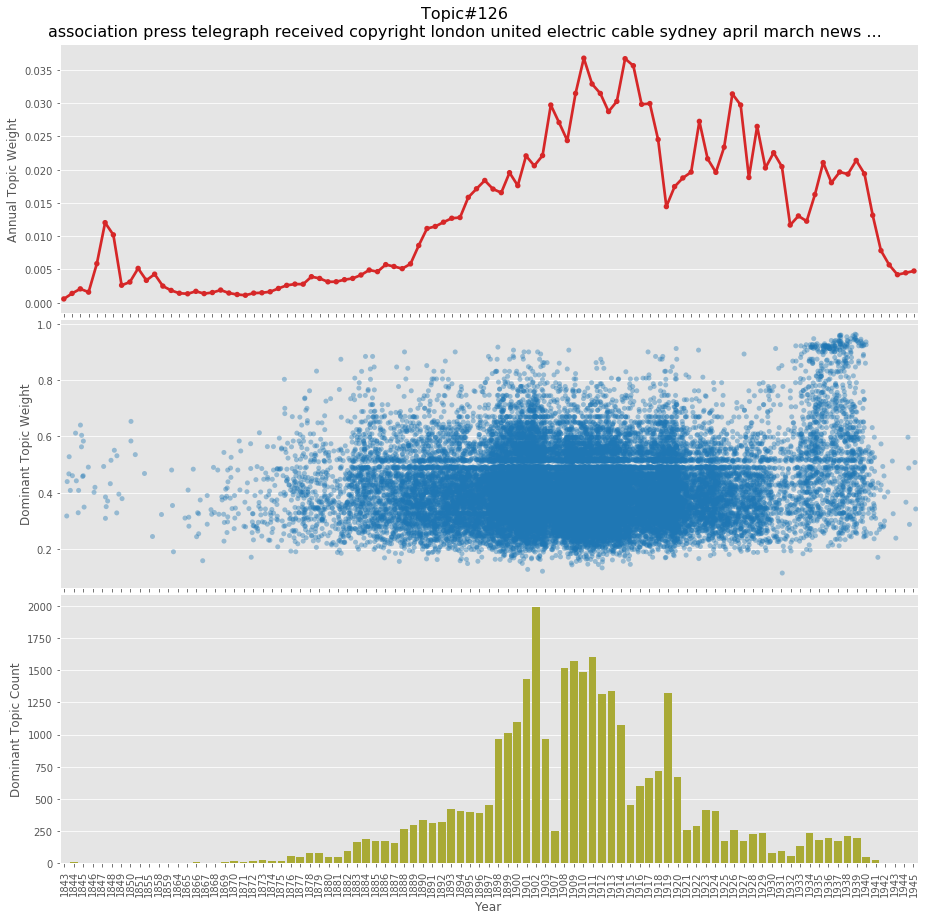

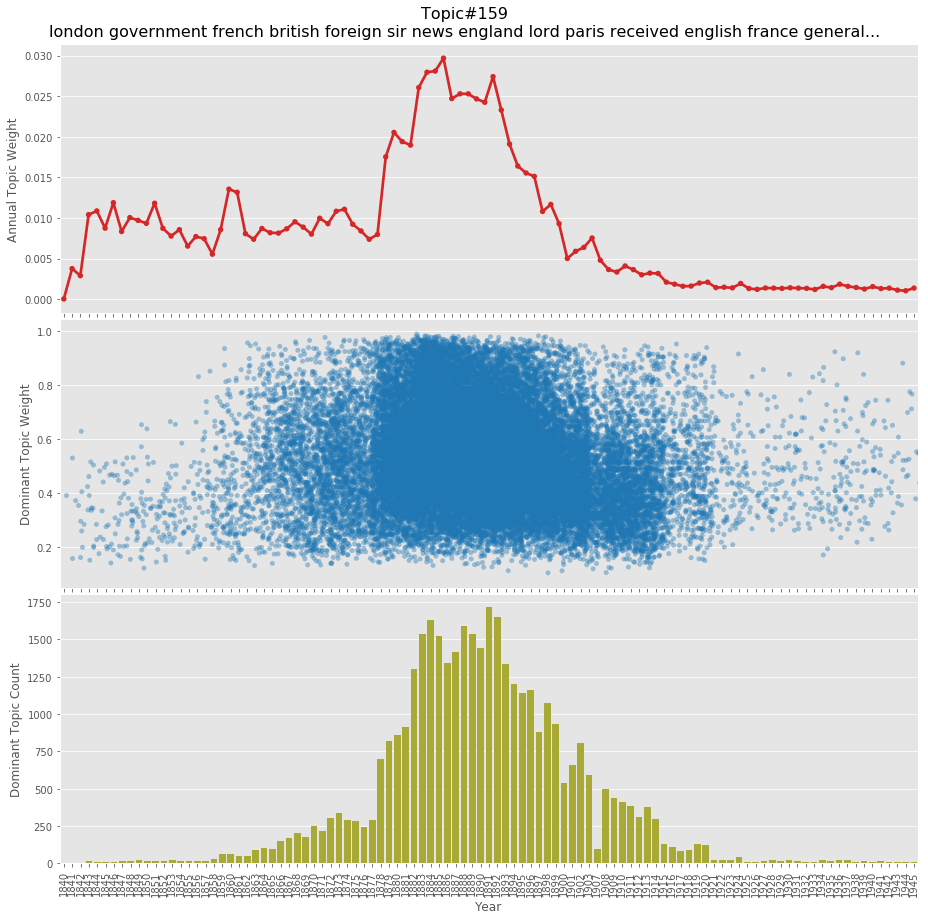

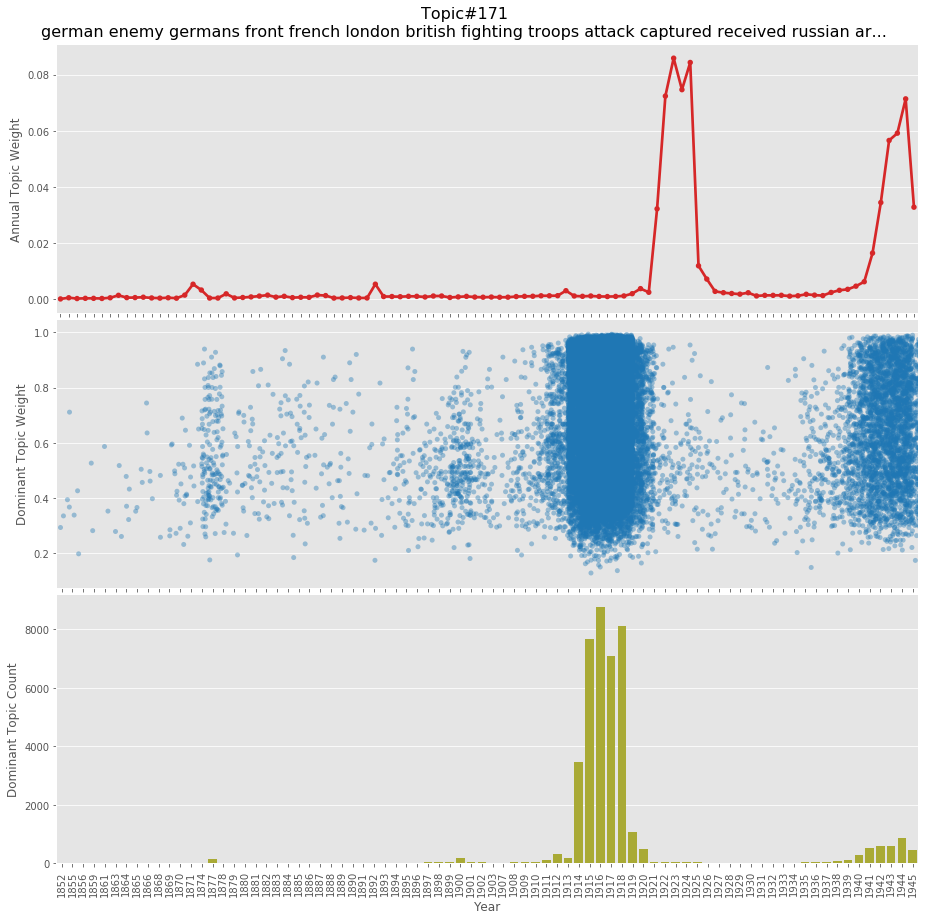

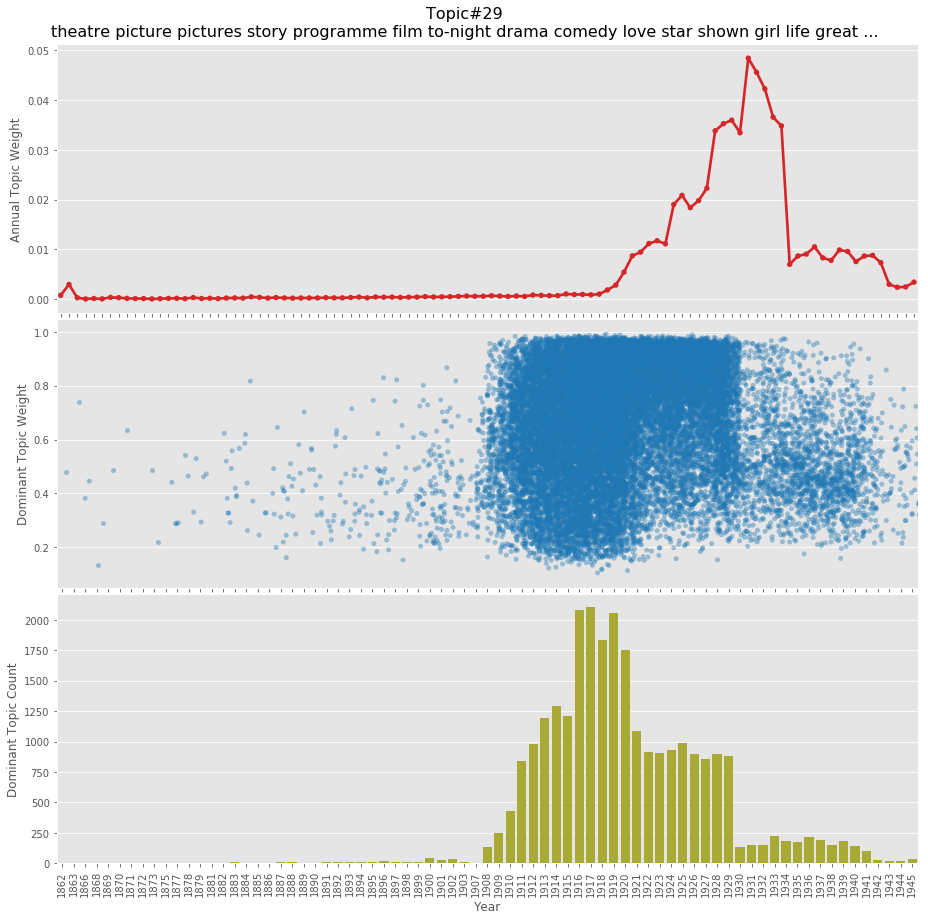

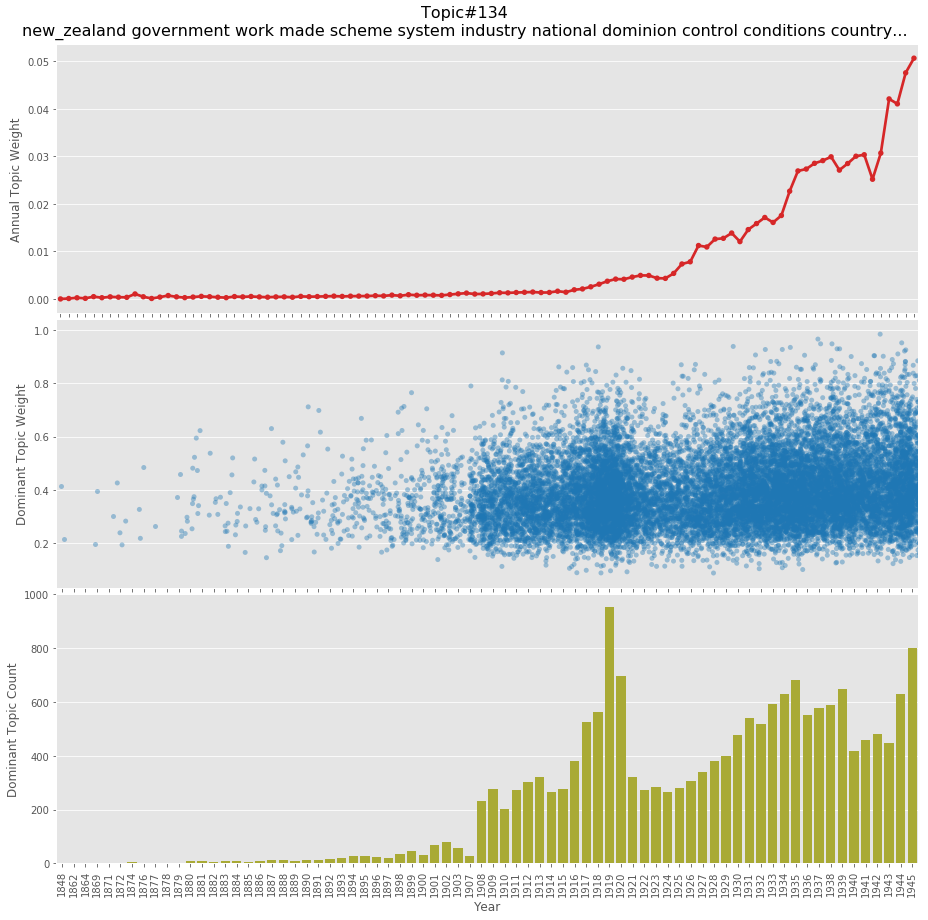

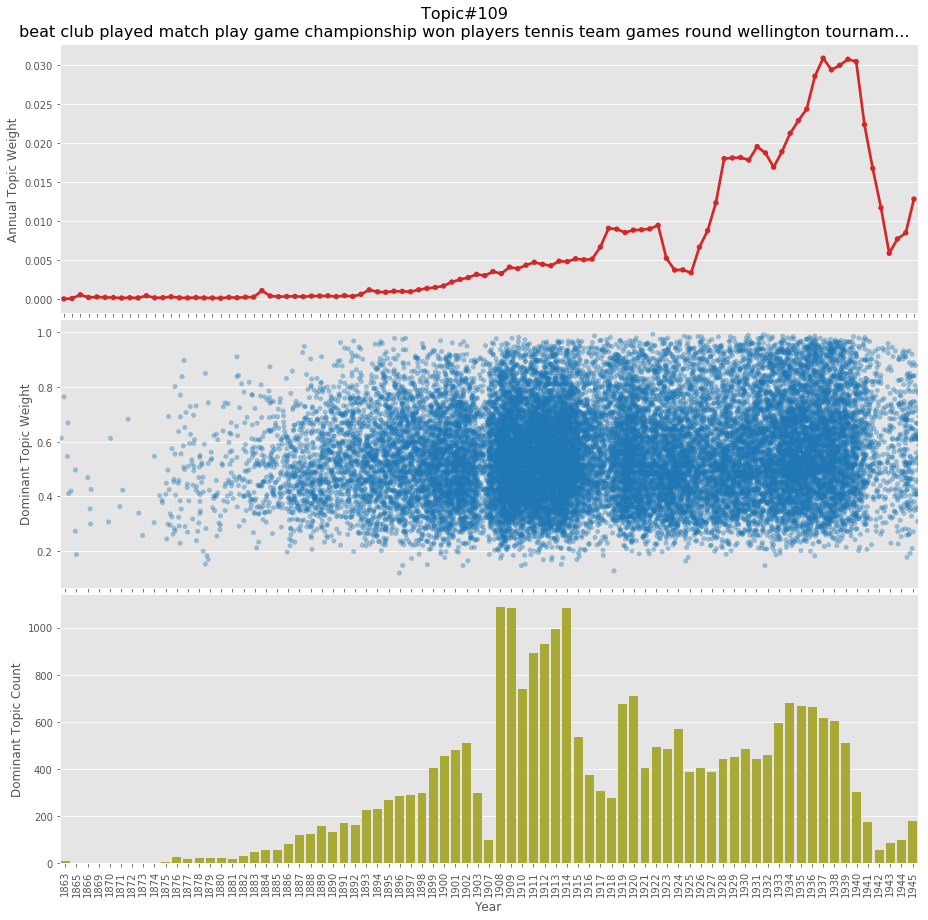

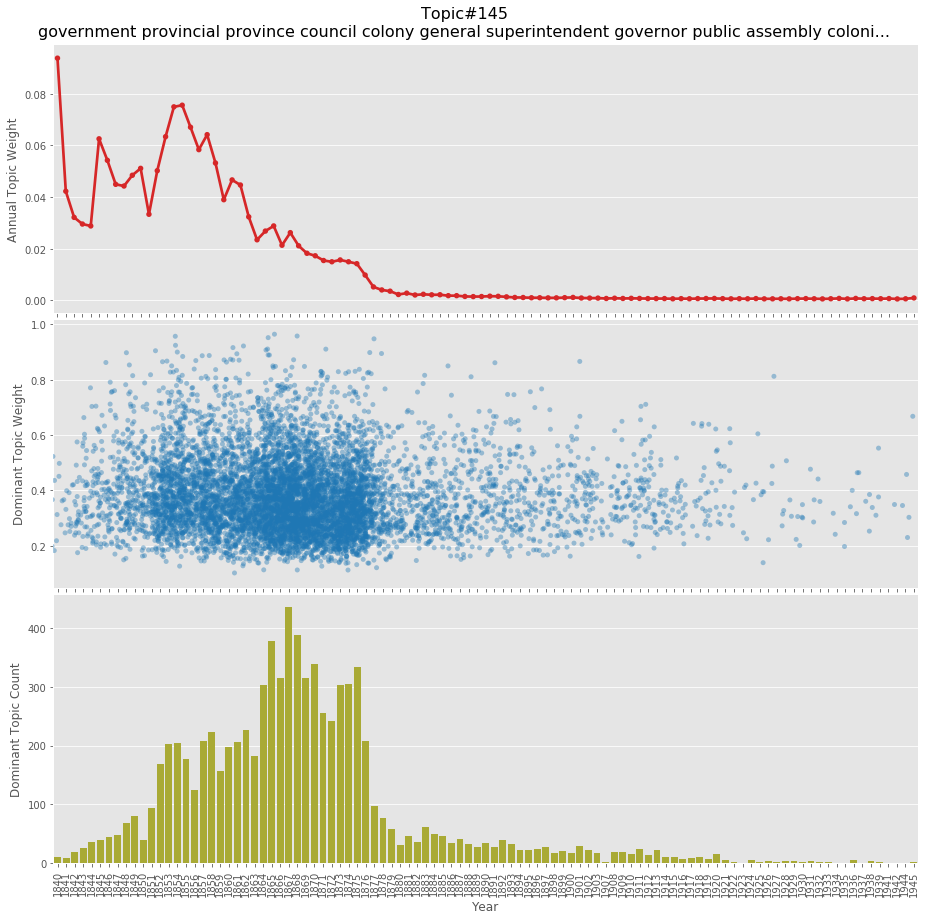

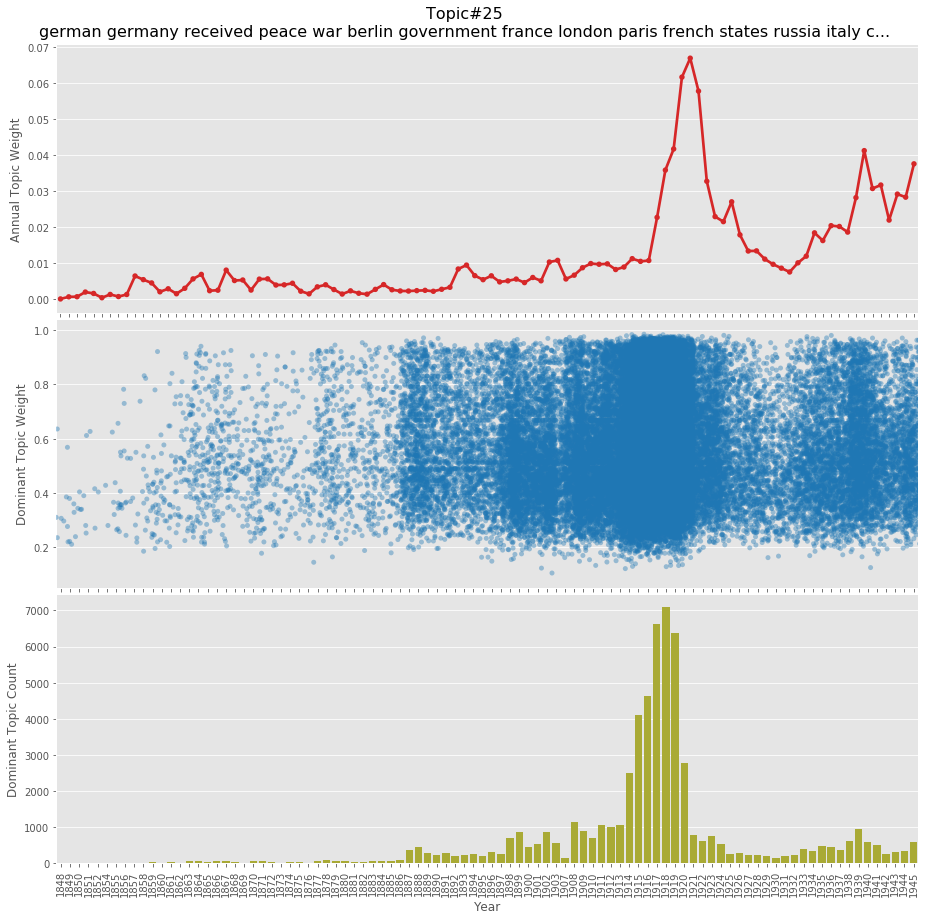

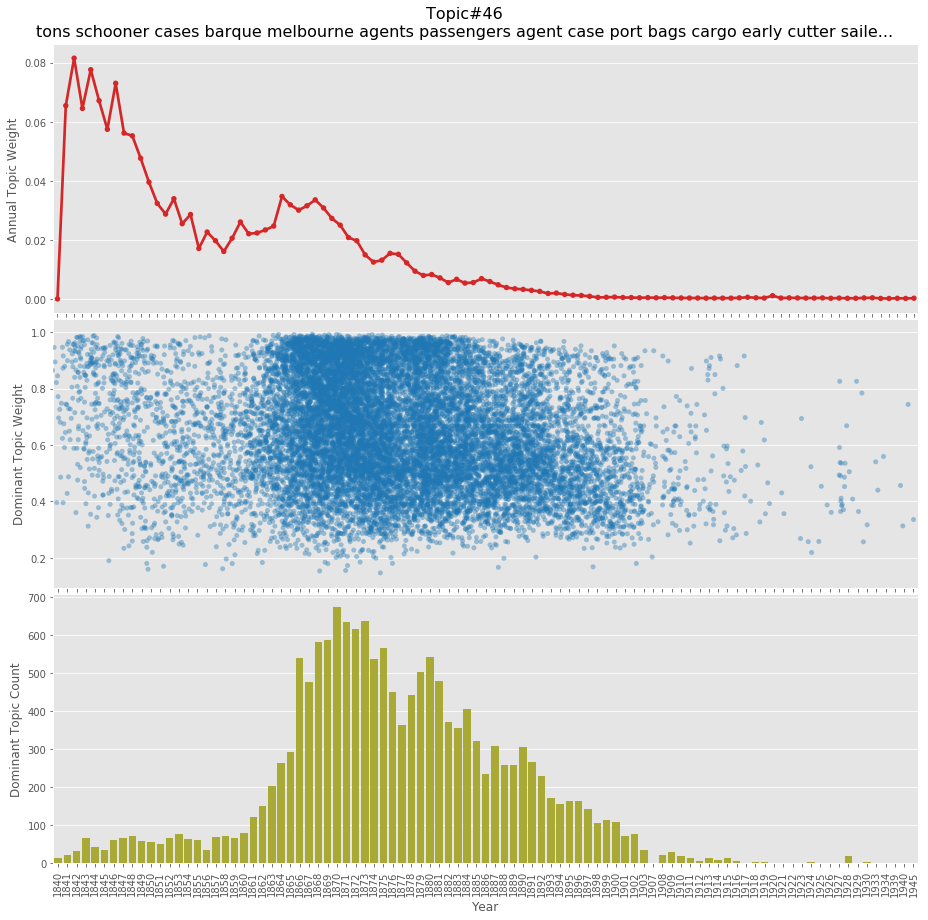

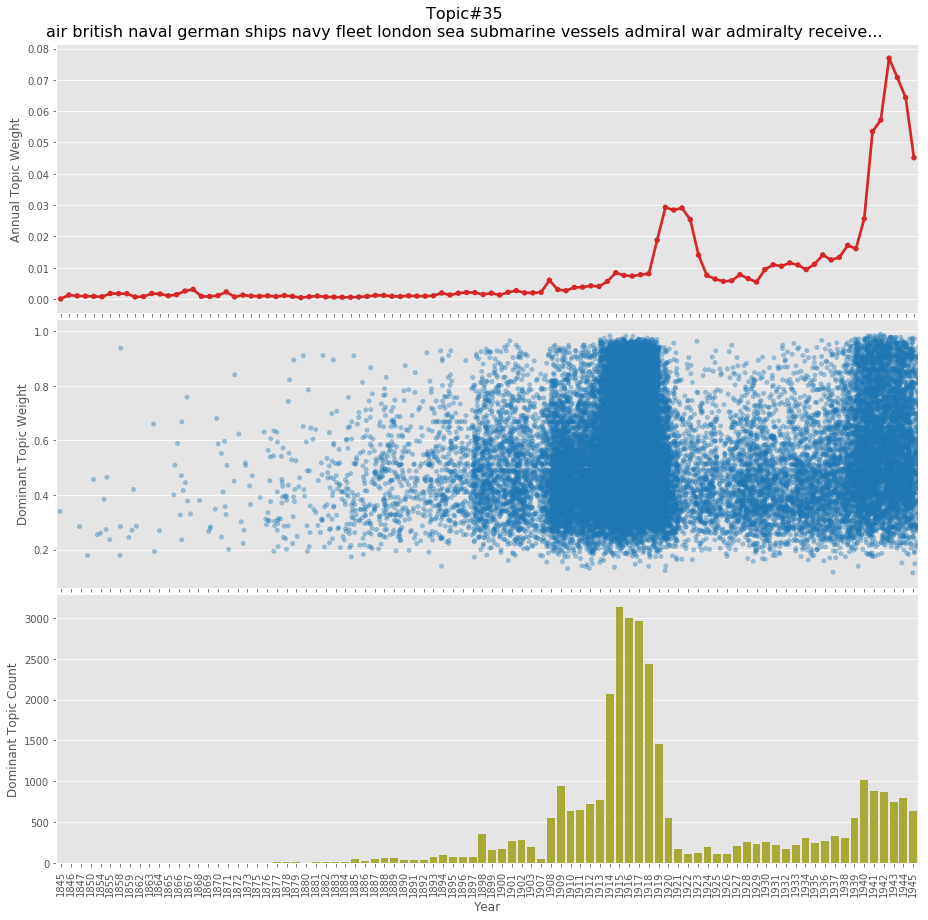

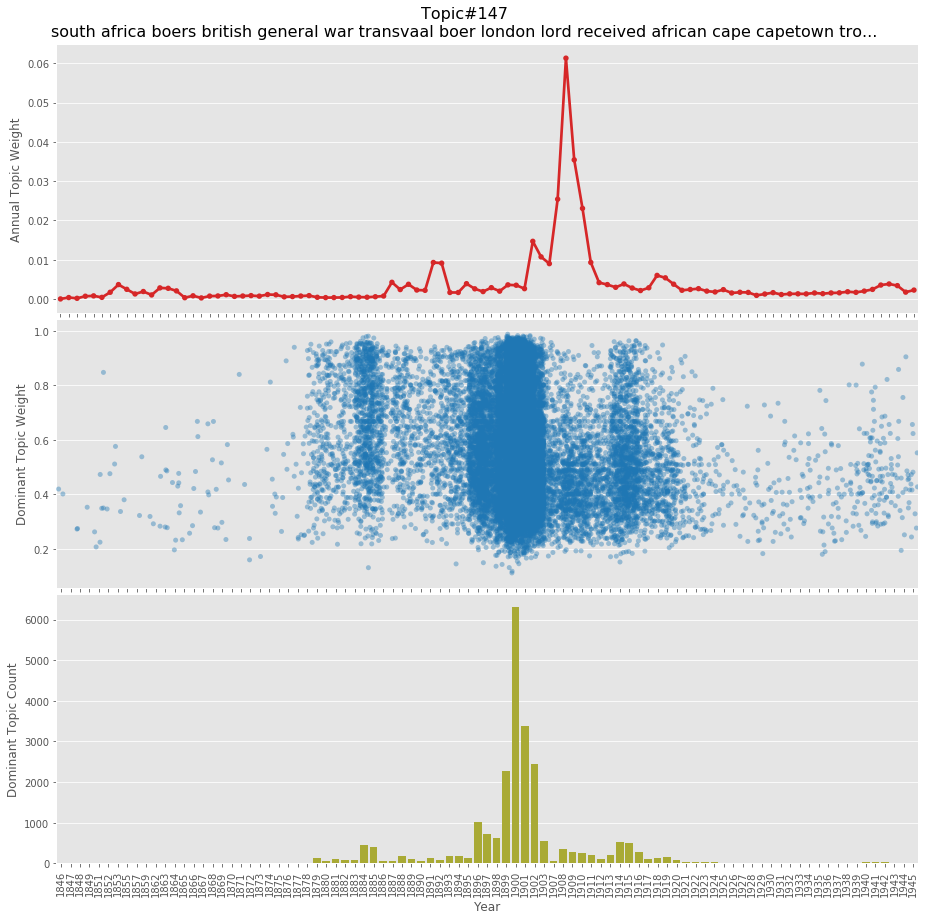

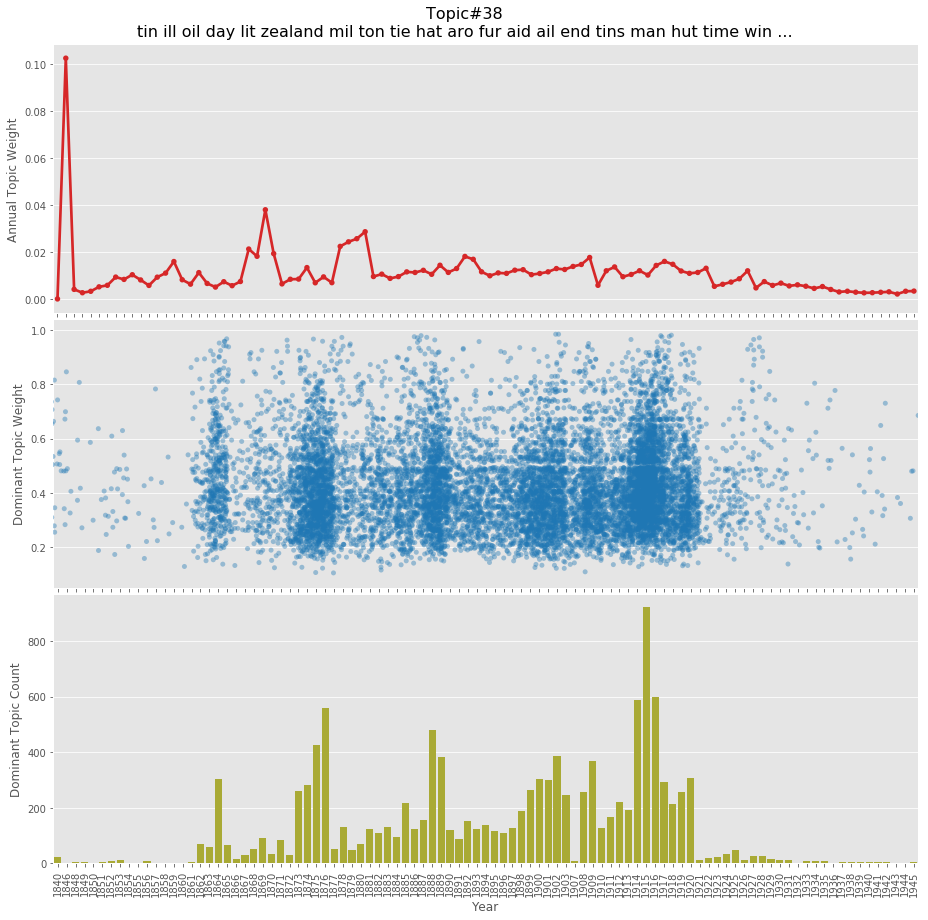

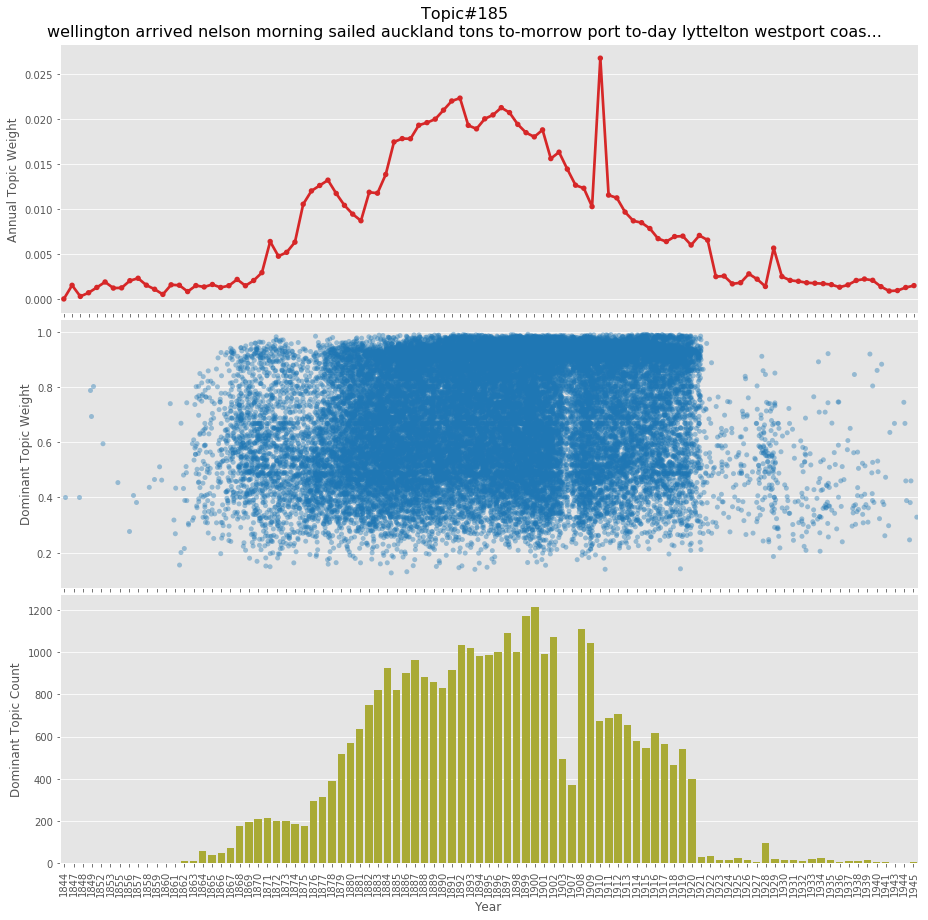

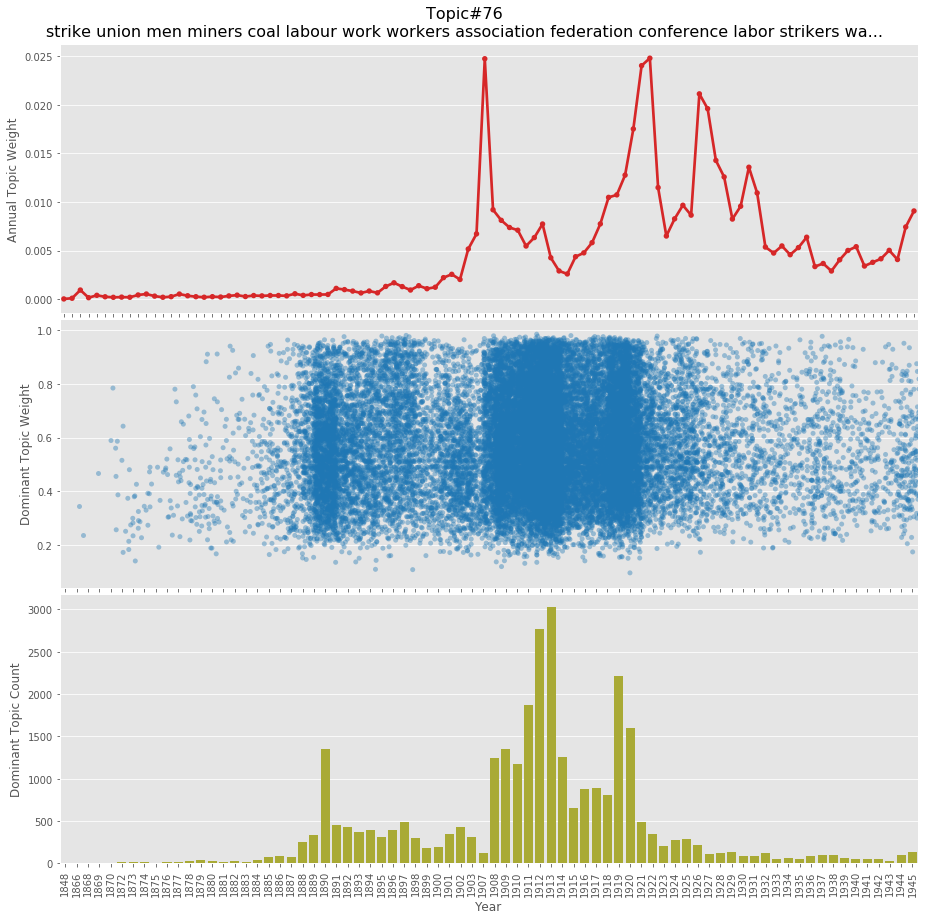

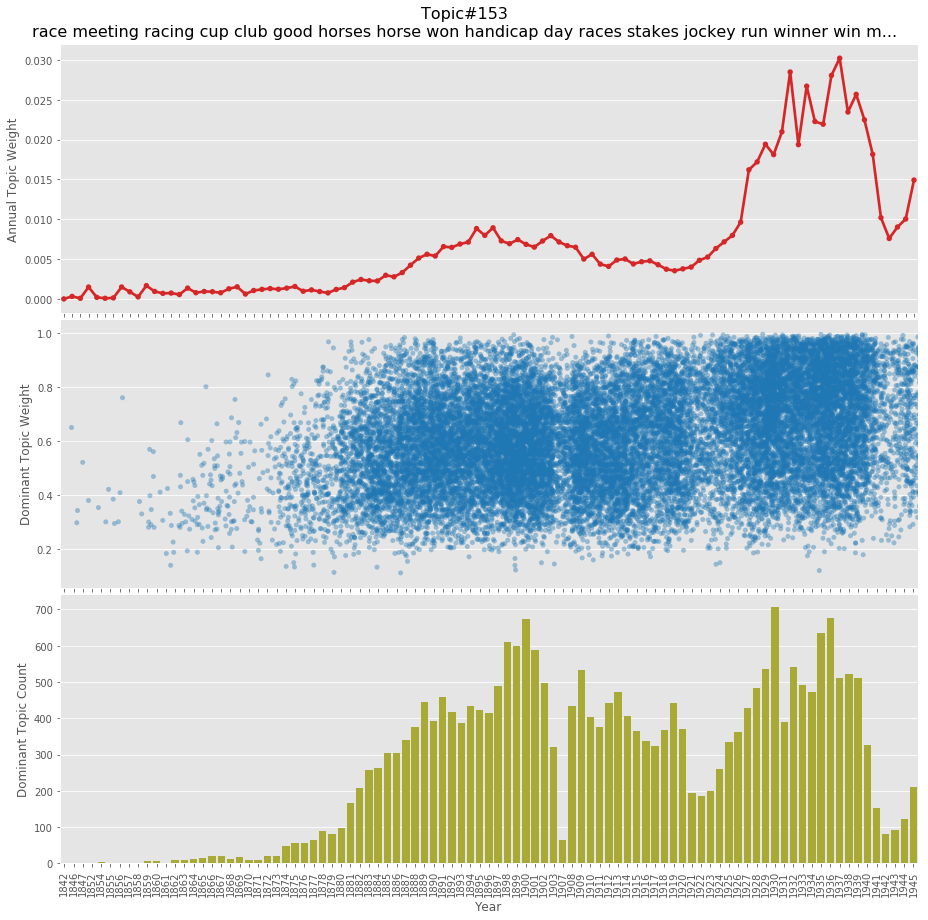

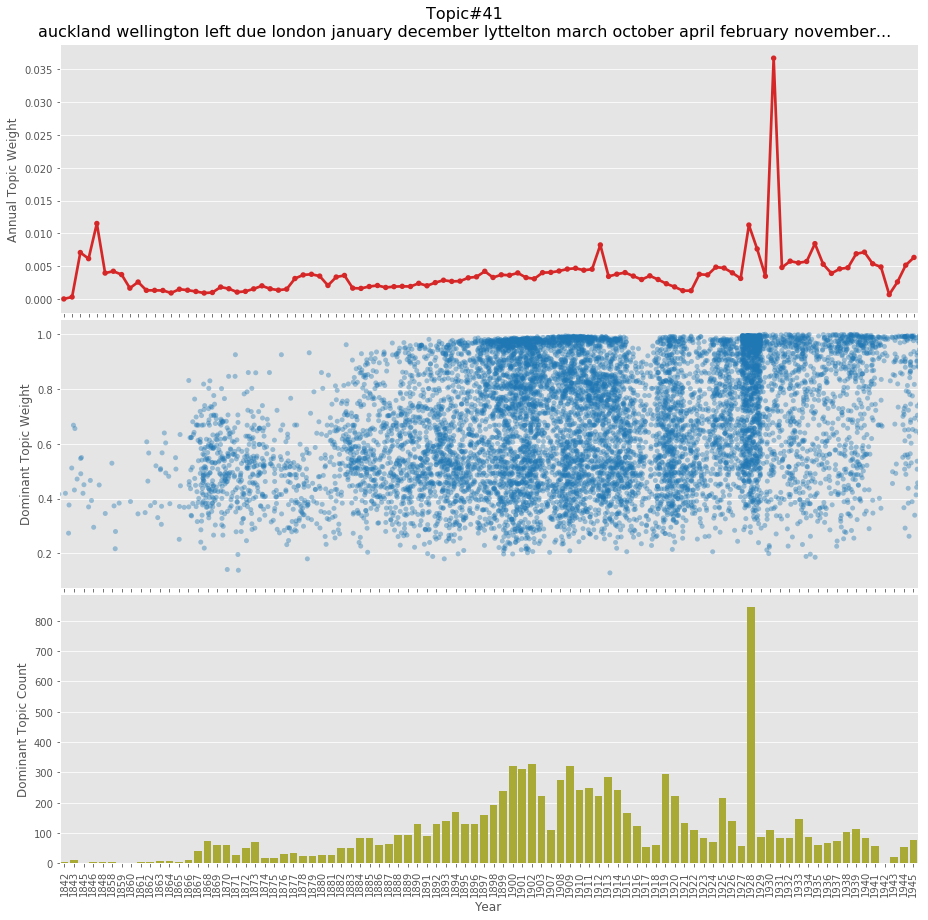

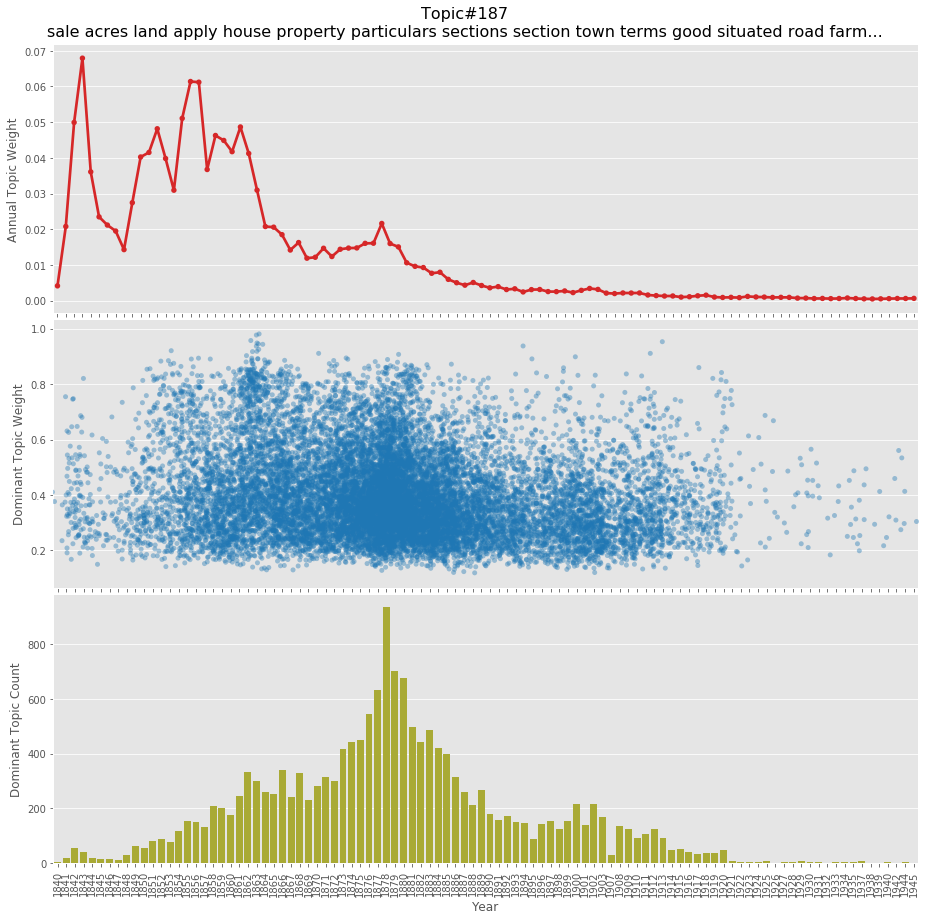

In [13]:
for topic in topic_list:
    plot_hot(topic, df_topics, df_domtopic, df_avgweight)

### 3.2 Several Interesting Topics

**Here we compare several interesting topics.**

In [14]:
topic_list = [25, 29, 171, 76]

df_topics_i = filter_topics(df_topics, topic_list).set_index('topic')
df_topics_i = df_topics_i.loc[topic_list]
col_order = df_topics_i.keywords.str.slice(0,60)+'...'
df_topics_i.head()

weight  \
topic            
25     0.01345   
29     0.00615   
171    0.00752   
76     0.00782   

                                                                                                                      keywords  
topic                                                                                                                           
25     german germany received peace war berlin government france london paris french states russia italy correspondent bri...  
29     theatre picture pictures story programme film to-night drama comedy love star shown girl life great feature supporti...  
171    german enemy germans front french london british fighting troops attack captured received russian artillery line sta...  
76     strike union men miners coal labour work workers association federation conference labor strikers wages received uni...

**Plot:**

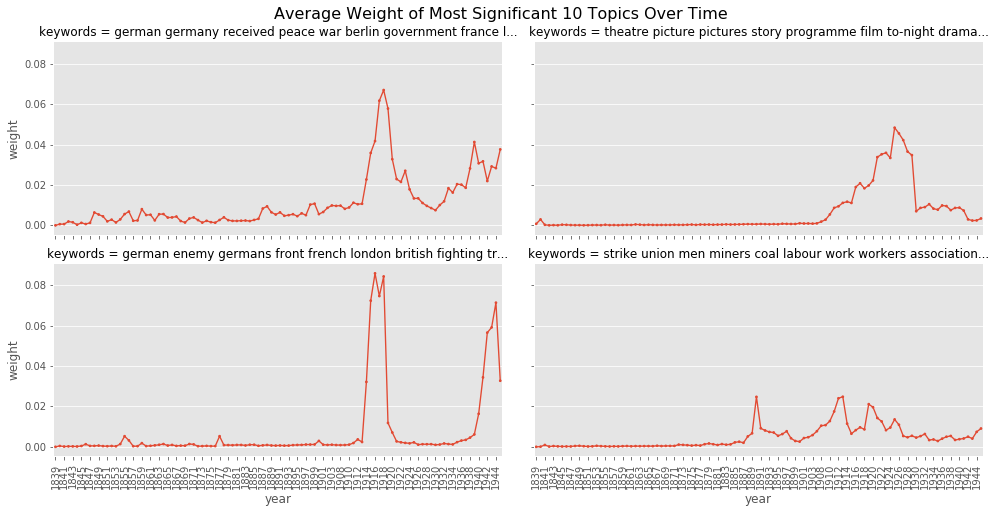

In [15]:
df_plt_avg = filter_topics(df_avgweight, topic_list)

plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.91,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Seems war, peace, entertainment and strike have kinds of connection, a good point to continue study.**

---

In [16]:
gc.collect()

113797